Epoch:0/100 Error_train:1.1143748868904777 Error_test:1.107887892429175


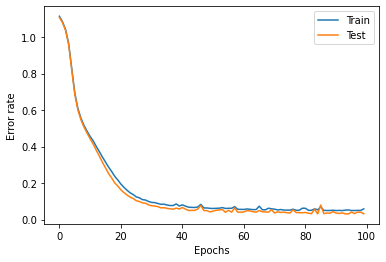

Accuracy Train: 98.0% Accuracy Test: 96.0%


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
#irisデータの読み込み
iris_data=datasets.load_iris()
input_data=iris_data.data
correct=iris_data.target
n_data=len(correct)#全サンプル数
#入力データの標準化（学習時間が短縮される。要論文）
ave_input=np.average(input_data,axis=0)
std_input=np.std(input_data,axis=0)
input_data=(input_data - ave_input)/ std_input
#出力データを０，１の表現にする
correct_data=np.zeros((n_data,3))
for i in range(n_data):
    correct_data[i,correct[i]]=1.0
#訓練データとテストデータの分割(訓練70％、テスト30％)
index=np.arange(n_data)
index_train=index[index%3!=0]
index_test=index[index%3==0]
input_train=input_data[index_train,:]
correct_train=correct_data[index_train,:]
input_test=input_data[index_test,:]
correct_test=correct_data[index_test,:]

n_train=input_train.shape[0]#訓練データのサンプル数

n_test=input_test.shape[0]#テストデータのサンプル数

#各パラメータ（可変）
#入力層のニューロン数
n_in=4
#中間層のニューロン数
n_mid=25
#出力層のニューロン数
n_out=3
#重みとバイアスの広がり具合
wb_width=0.1
#学習係数
eta=0.01

epoch=100
#全訓練データの使用回数
batch_size=8
#一度の学習で使うサンプル数
interval=100
#経過の表示間隔
#クラス定義
class BaseLayer:
    def __init__(self,n_upper,n):
        #重みとバイアス
        self.w=wb_width*np.random.randn(n_upper,n) 
        #各層についてランダムに重みとバイアスを初期値として入力
        self.b=wb_width*np.random.randn(n)
        
    def update(self,eta):
        self.w-=eta*self.grad_w
        self.b-=eta*self.grad_b
        
#中間層クラス（クラスの継承含む）
class MiddleLayer(BaseLayer):
    def forward(self,x):
        self.x=x
        self.u=np.dot(x,self.w)+self.b
        self.y=np.where(self.u<=0,0,self.u)
        #relu
    def backward(self,grad_y):
        delta =grad_y*np.where(self.u<=0,0,1)
        #reluの微分
        self.grad_w=np.dot(self.x.T,delta)
        self.grad_b=np.sum(delta,axis=0)
        
        self.grad_x=np.dot(delta,self.w.T)

class OutputLayer(BaseLayer):
    def forward(self,x):
        self.x=x
        u=np.dot(x,self.w)+self.b
        
        self.y=np.exp(u)/np.sum(np.exp(u),axis=1,keepdims=True)
        #ソフトマックス関数
    def backward(self,t):
        delta=self.y -t    #p.161,式05-32 活性化関数がReLUなので少し違う
        
        self.grad_w=np.dot(self.x.T,delta)
        self.grad_b=np.sum(delta,axis=0)
        
        self.grad_x=np.dot(delta,self.w.T)
#各層の初期化
middle_layer_1=MiddleLayer(n_in,n_mid)
middle_layer_2=MiddleLayer(n_mid,n_mid)
output_layer=OutputLayer(n_mid,n_out)
#順伝搬
def forward_propagation(x):
    middle_layer_1.forward(x)
    middle_layer_2.forward(middle_layer_1.y)
    output_layer.forward(middle_layer_2.y)
    
#逆伝搬
def backpropagation(t):
    output_layer.backward(t)
    middle_layer_2.backward(output_layer.grad_x)
    middle_layer_1.backward(middle_layer_2.grad_x)
    
#重み、バイアスの更新
def update_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)
    
#交差エントロピー誤差を計算
def get_error(t,batch_size):
    return -np.sum(t*np.log(output_layer.y+1e-7))/batch_size
#上記誤差の記録
train_error_x=[]
train_error_y=[]
test_error_x=[]
test_error_y=[]

n_batch=n_train//batch_size 
#1エポック当たりのバッチ数


for i in range(epoch):
        #訓練データ、テストデータに対する誤差の計測
        forward_propagation(input_train)
        error_train=get_error(correct_train,n_train)
        forward_propagation(input_test)
        error_test=get_error(correct_test,n_test)
        #誤差の記録
        test_error_x.append(i)
        test_error_y.append(error_test)
        train_error_x.append(i)
        train_error_y.append(error_train)
        
        #経過の表示
        if i%interval==0:
            print("Epoch:"+str(i)+"/"+str(epoch),
                 "Error_train:"+str(error_train),
                 "Error_test:"+str(error_test))
            
        
        
        #学習
        index_random=np.arange(n_train)
        np.random.shuffle(index_random)#インデックスシャッフル
        for j in range(n_batch):
            
            #ミニバッチを取り出す
            mb_index=index_random[j*batch_size:(j+1)*batch_size]
            x=input_train[mb_index,:]
            t=correct_train[mb_index,:]
            
            #順伝搬と逆伝搬
            forward_propagation(x)
            backpropagation(t)
            
            #重み、バイアスの更新
            update_wb()
            


            
            
#誤差記録をグラフ表示
plt.plot(train_error_x,train_error_y,label="Train")
plt.plot(test_error_x,test_error_y,label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.close()
#正解率の測定
forward_propagation(input_train)
count_train=np.sum(np.argmax(output_layer.y,axis=1)==np.argmax(correct_train,axis=1))
forward_propagation(input_test)
count_test=np.sum(np.argmax(output_layer.y,axis=1)==np.argmax(correct_test,axis=1))

print("Accuracy Train:",str(count_train/n_train*100)+"%","Accuracy Test:",str(count_test/n_test*100)+"%")